In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
file_path = "C:/Users/Albin/Desktop/TIME_SERIES_ANALYSIS/Project/chennai_reservoir_levels.csv"
df = pd.read_csv(file_path)

In [3]:
df.head(10)

,Date,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
0,01-01-2004,3.9,0.0,268.0,0.0
1,02-01-2004,3.9,0.0,268.0,0.0
2,03-01-2004,3.9,0.0,267.0,0.0
3,04-01-2004,3.9,0.0,267.0,0.0
4,05-01-2004,3.8,0.0,267.0,0.0
5,06-01-2004,3.8,0.0,266.0,0.0
6,07-01-2004,3.8,0.0,266.0,0.0
7,08-01-2004,3.7,0.0,265.0,0.0
8,09-01-2004,3.7,0.0,264.0,0.0
9,10-01-2004,3.7,0.0,264.0,0.0


In [4]:
df.shape

(6182, 5)

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6182 entries, 0 to 6181
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             6182 non-null   object 
 1   POONDI           6182 non-null   float64
 2   CHOLAVARAM       6182 non-null   float64
 3   REDHILLS         6182 non-null   float64
 4   CHEMBARAMBAKKAM  6182 non-null   float64
dtypes: float64(4), object(1)
memory usage: 241.6+ KB
None


In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(by='Date')


In [7]:
missing_values = df.isnull().sum()

print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [8]:
df.fillna(method='ffill', inplace=True) 

C:\Users\Albin\AppData\Local\Temp\ipykernel_21876\1832164728.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [9]:
for col in ['POONDI', 'CHOLAVARAM', 'REDHILLS', 'CHEMBARAMBAKKAM']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

In [10]:
summary_stats = df.describe()
print("Missing Values:\n", df.isnull().sum())
print(summary_stats)

Missing Values:
 Date               0
POONDI             0
CHOLAVARAM         0
REDHILLS           0
CHEMBARAMBAKKAM    0
dtype: int64
                      Date       POONDI   CHOLAVARAM     REDHILLS  \
count                 6182  6182.000000  6182.000000  6182.000000   
mean   2012-06-17 12:00:00  1106.739588   226.404589  1592.321652   
min    2004-01-01 00:00:00     0.900000     0.000000     0.000000   
25%    2008-03-25 06:00:00   202.000000    26.000000   847.250000   
50%    2012-06-17 12:00:00   783.150000    89.000000  1685.000000   
75%    2016-09-09 18:00:00  1918.000000   411.000000  2320.000000   
max    2020-12-03 00:00:00  3231.000000   896.000000  3300.000000   
std                    NaN  1004.555050   266.886855   915.243744   

       CHEMBARAMBAKKAM  
count      6182.000000  
mean       1321.460555  
min           0.000000  
25%         459.250000  
50%        1264.000000  
75%        2046.750000  
max        3396.000000  
std         951.791133  


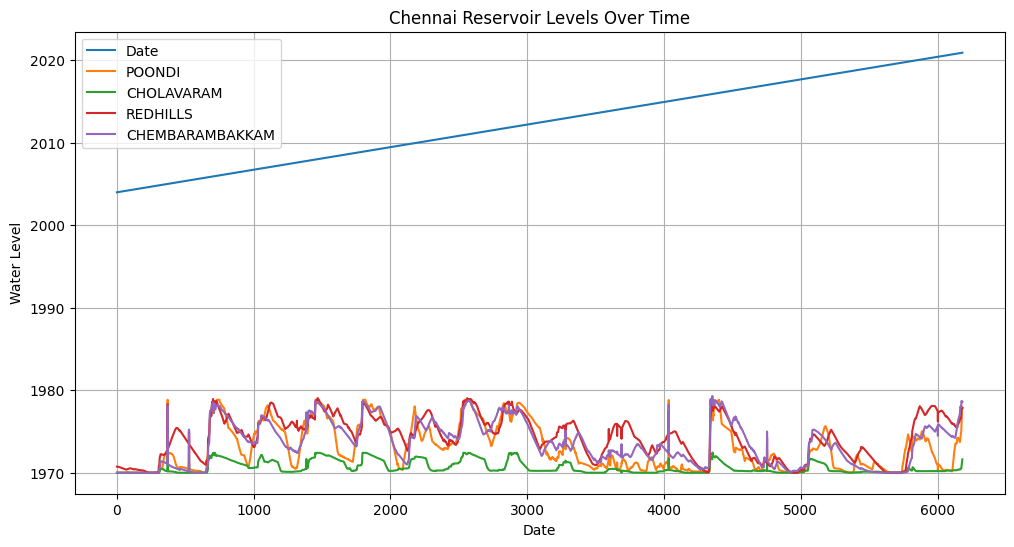

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.xlabel("Date")
plt.ylabel("Water Level")
plt.title("Chennai Reservoir Levels Over Time")
plt.legend()
plt.grid()
plt.show()


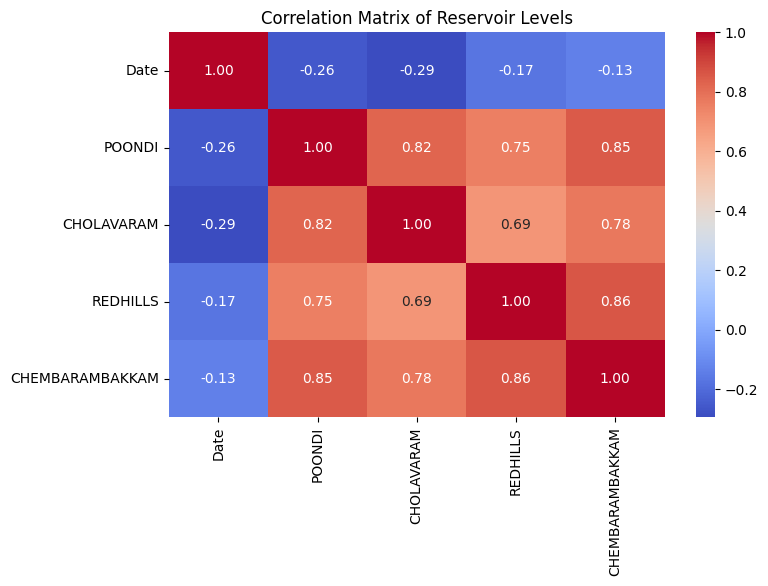

In [12]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Reservoir Levels")
plt.show()


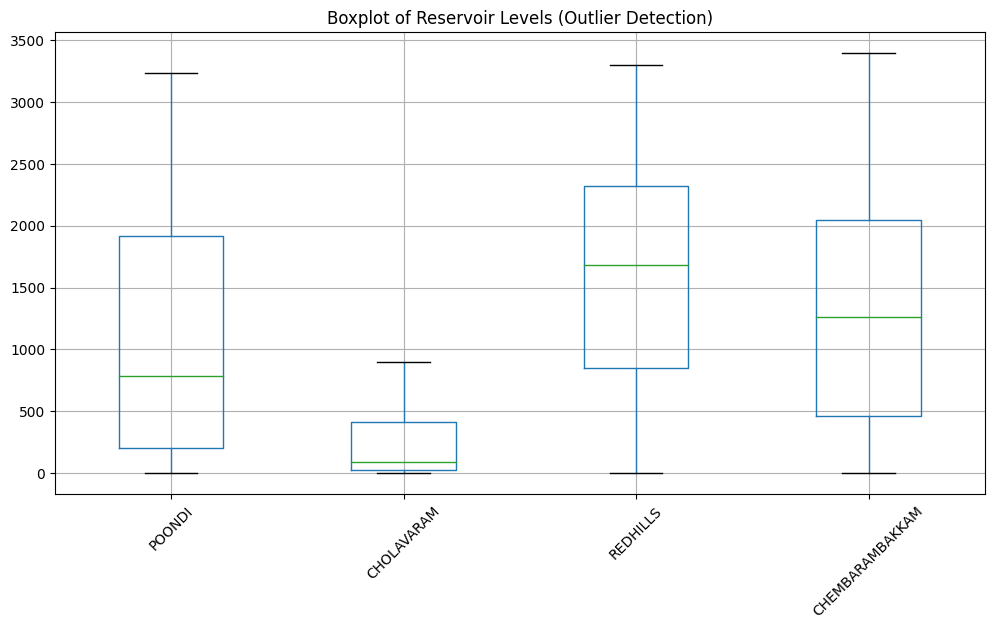

In [13]:
plt.figure(figsize=(12, 6))
df.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of Reservoir Levels (Outlier Detection)")
plt.show()


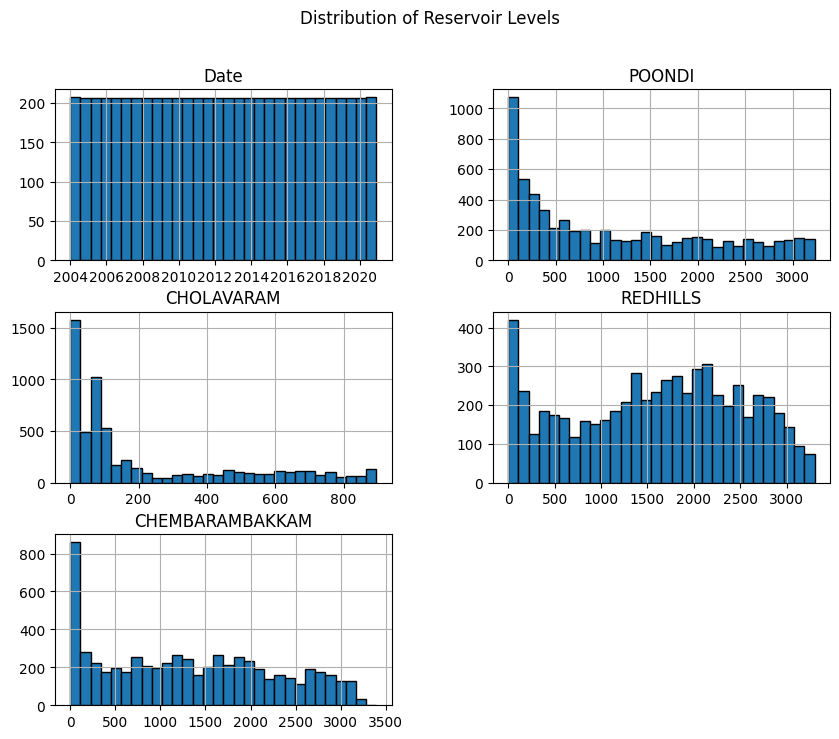

In [14]:
df.hist(figsize=(10, 8), bins=30, edgecolor="black")
plt.suptitle("Distribution of Reservoir Levels")
plt.show()


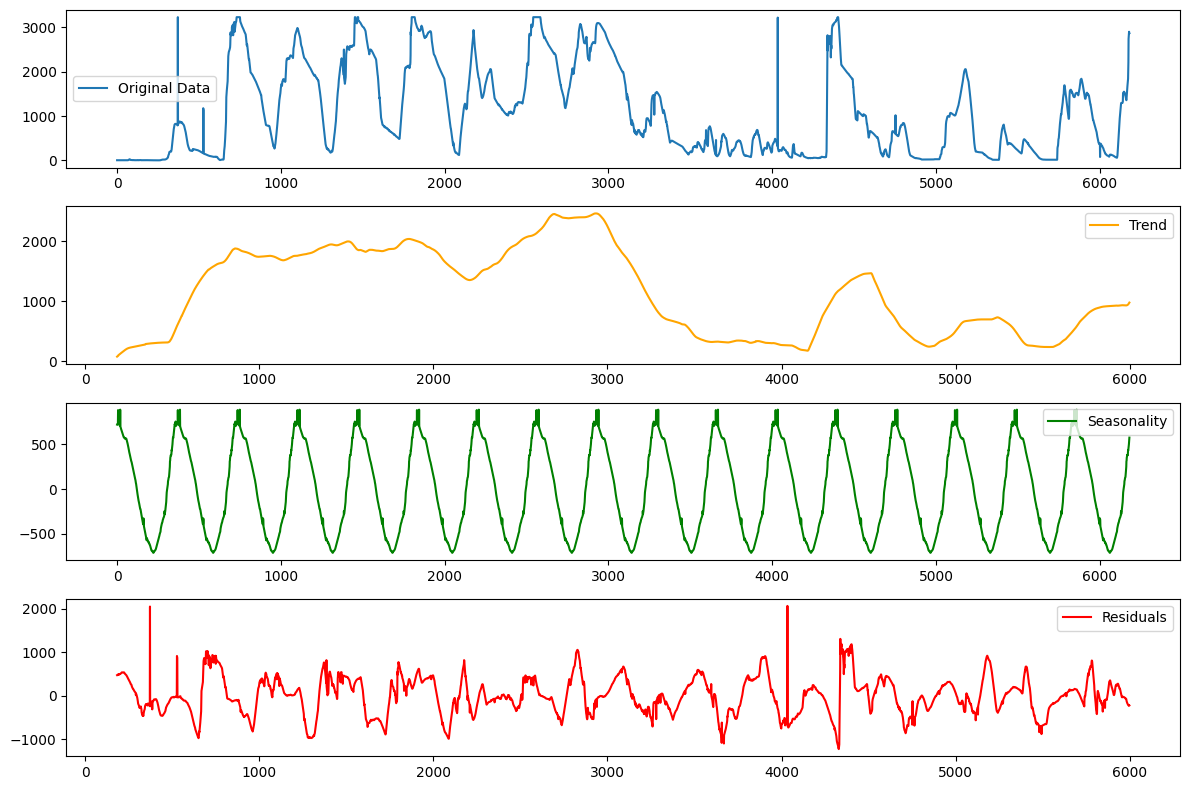

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

reservoir_column = "POONDI"

decomposition = seasonal_decompose(df[reservoir_column], model='additive', period=365)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df[reservoir_column], label="Original Data")
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label="Trend", color='orange')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label="Seasonality", color='green')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label="Residuals", color='red')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
from statsmodels.tsa.stattools import adfuller

for column in df.columns:
    if column != "Date":
        result = adfuller(df[column].dropna())
        print(f"\n### ADF Test for {column} ###")
        print("ADF Statistic:", result[0])
        print("p-value:", result[1])
        print("Critical Values:", result[4])

        if result[1] < 0.05:
            print(f"{column} is stationary (p-value < 0.05).")
        else:
            print(f"{column} is non-stationary (p-value >= 0.05).")



### ADF Test for POONDI ###
ADF Statistic: -3.949555265857681
p-value: 0.001698951969319451
Critical Values: {'1%': -3.4314109835286453, '5%': -2.8620088595072937, '10%': -2.567019571125975}
POONDI is stationary (p-value < 0.05).

### ADF Test for CHOLAVARAM ###
ADF Statistic: -4.167171769327192
p-value: 0.0007484740944299103
Critical Values: {'1%': -3.431410295408432, '5%': -2.8620085554741395, '10%': -2.567019409281592}
CHOLAVARAM is stationary (p-value < 0.05).

### ADF Test for REDHILLS ###
ADF Statistic: -4.143432921458722
p-value: 0.0008202393949611853
Critical Values: {'1%': -3.4314111556982785, '5%': -2.862008935577242, '10%': -2.567019611619896}
REDHILLS is stationary (p-value < 0.05).

### ADF Test for CHEMBARAMBAKKAM ###
ADF Statistic: -3.4844903521549546
p-value: 0.008394464178663684
Critical Values: {'1%': -3.4314111556982785, '5%': -2.862008935577242, '10%': -2.567019611619896}
CHEMBARAMBAKKAM is stationary (p-value < 0.05).


<Figure size 800x500 with 0 Axes>

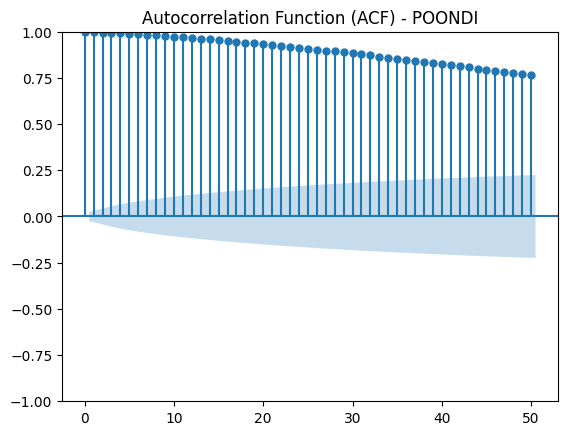

<Figure size 800x500 with 0 Axes>

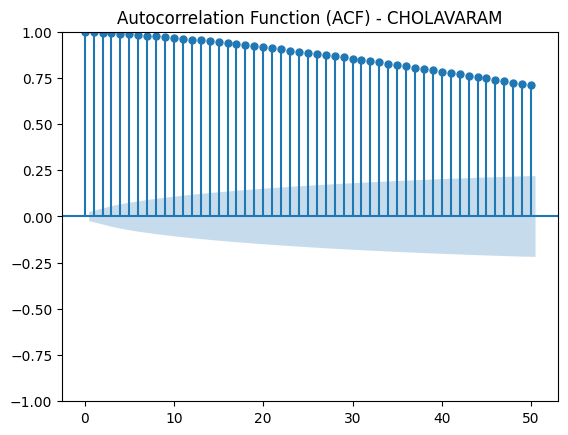

<Figure size 800x500 with 0 Axes>

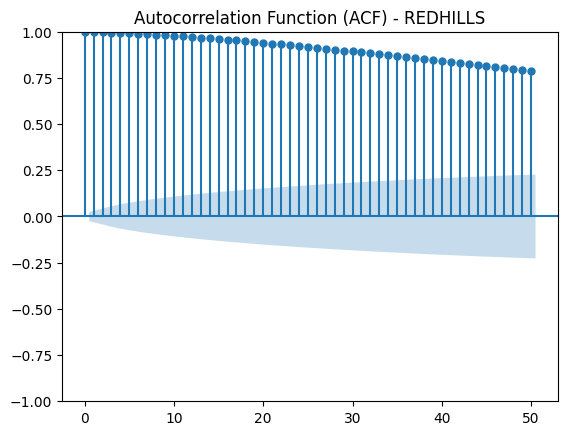

<Figure size 800x500 with 0 Axes>

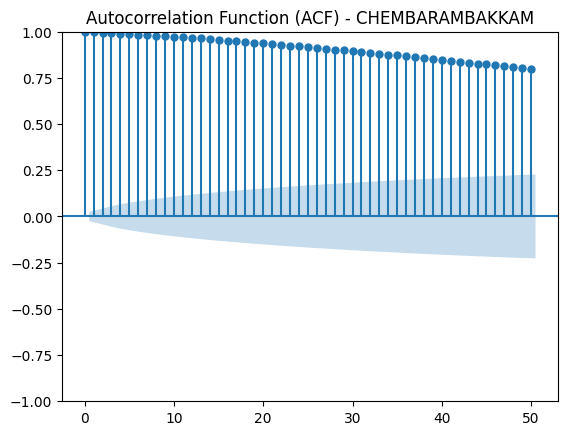

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
for column in df.columns:
    if column != "Date":
        plt.figure(figsize=(8, 5))
        plot_acf(df[column], lags=50)
        plt.title(f"Autocorrelation Function (ACF) - {column}")
        plt.show()


<Figure size 800x500 with 0 Axes>

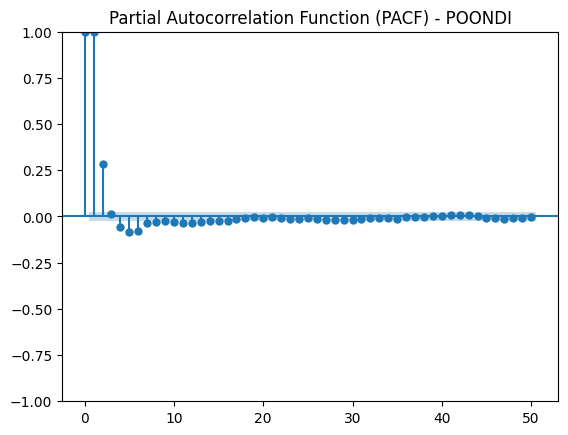

<Figure size 800x500 with 0 Axes>

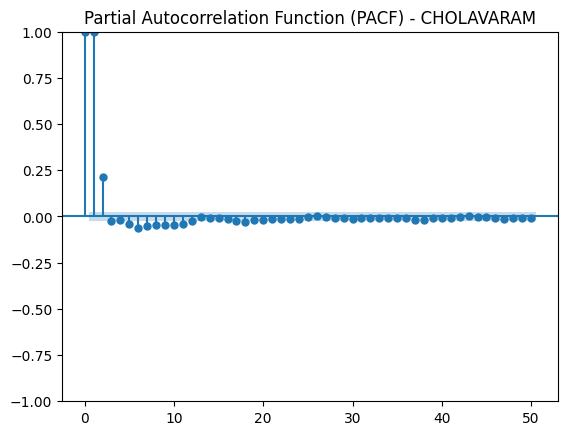

<Figure size 800x500 with 0 Axes>

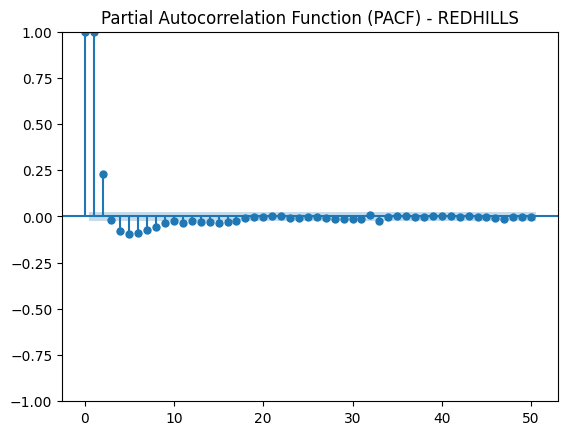

<Figure size 800x500 with 0 Axes>

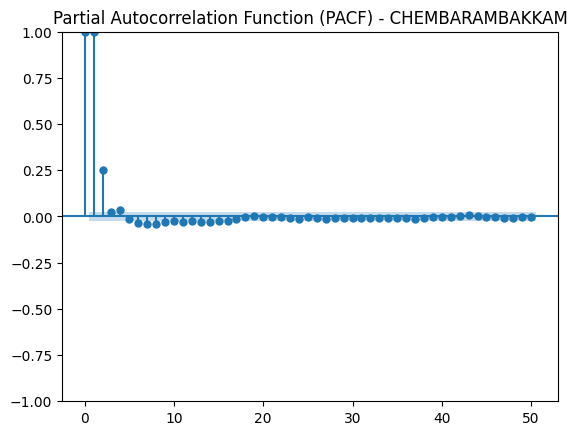

In [18]:
for column in df.columns:
    if column != "Date":
        plt.figure(figsize=(8, 5))
        plot_pacf(df[column], lags=50)
        plt.title(f"Partial Autocorrelation Function (PACF) - {column}")
        plt.show()


In [19]:
for col in ['POONDI', 'CHOLAVARAM', 'REDHILLS', 'CHEMBARAMBAKKAM']:
    print(f"\nFinding optimal SARIMA parameters for {col}")
    auto_model = auto_arima(df[col], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
    order, seasonal_order = auto_model.order, auto_model.seasonal_order
    
    print(f"Optimal Order for {col}: {order}")
    print(f"Optimal Seasonal Order for {col}: {seasonal_order}")
    
    model = SARIMAX(df[col], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_fit = model.fit()
    print(sarima_fit.summary())


Finding optimal SARIMA parameters for POONDI
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=70681.871, Time=10.27 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=71577.841, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=70918.325, Time=1.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=70974.556, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=71576.053, Time=0.26 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=70679.869, Time=9.70 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=70677.939, Time=3.25 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=70679.869, Time=9.43 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=70678.474, Time=1.71 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=70926.817, Time=1.51 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=70679.931, Time=5.74 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=70680.066, Time=7.16 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=70930.874, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[12] i

c:\Users\Albin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                           CHOLAVARAM   No. Observations:                 6182
Model:             SARIMAX(4, 1, 2)x(0, 0, [1], 12)   Log Likelihood              -27779.770
Date:                              Thu, 24 Apr 2025   AIC                          55575.540
Time:                                      12:33:27   BIC                          55629.354
Sample:                                           0   HQIC                         55594.202
                                             - 6182                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9705      0.167      5.801      0.000       0.643       1.298
ar.L2         -0.00

In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

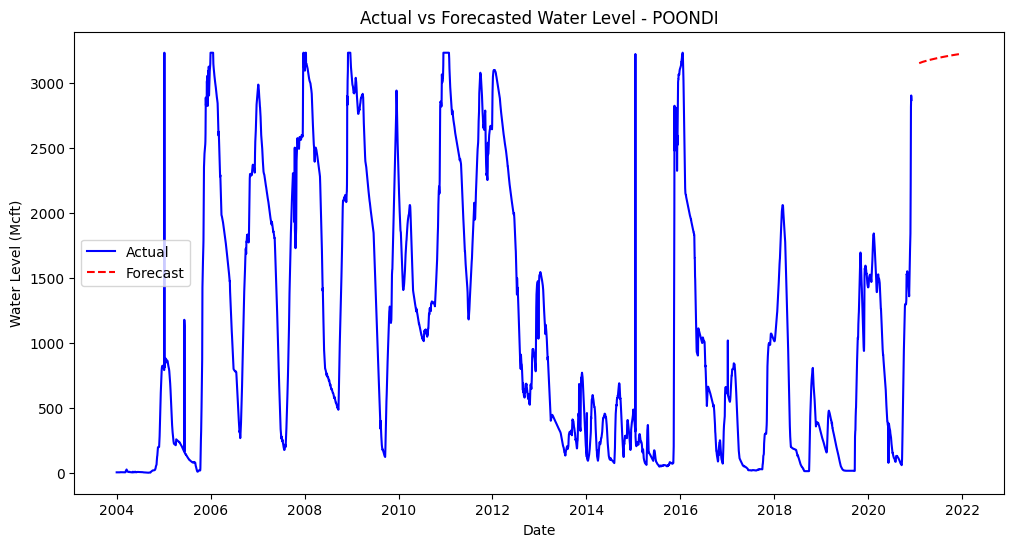

Model Performance for POONDI - MSE: 644978.72, RMSE: 803.11


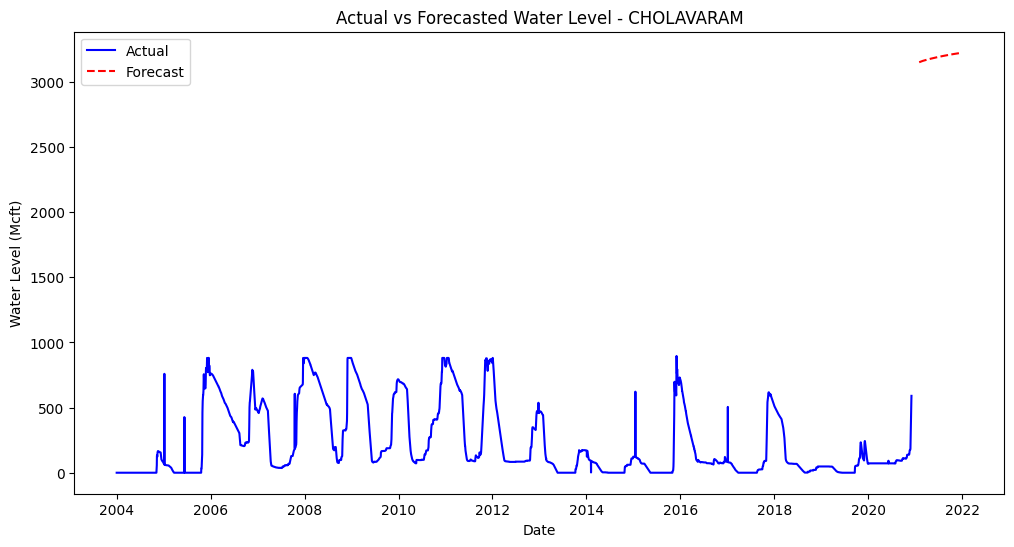

Model Performance for CHOLAVARAM - MSE: 7374292.99, RMSE: 2715.56


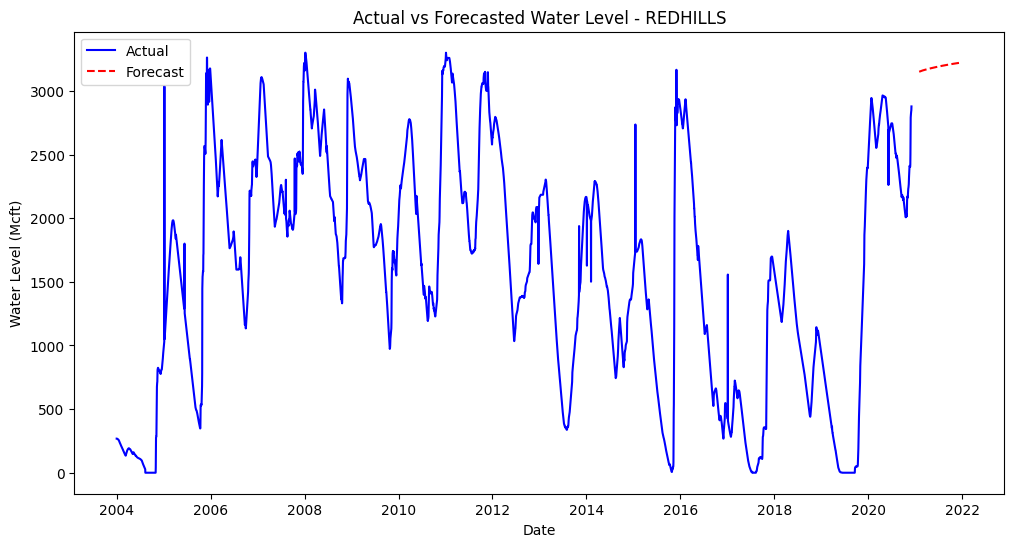

Model Performance for REDHILLS - MSE: 147394.65, RMSE: 383.92


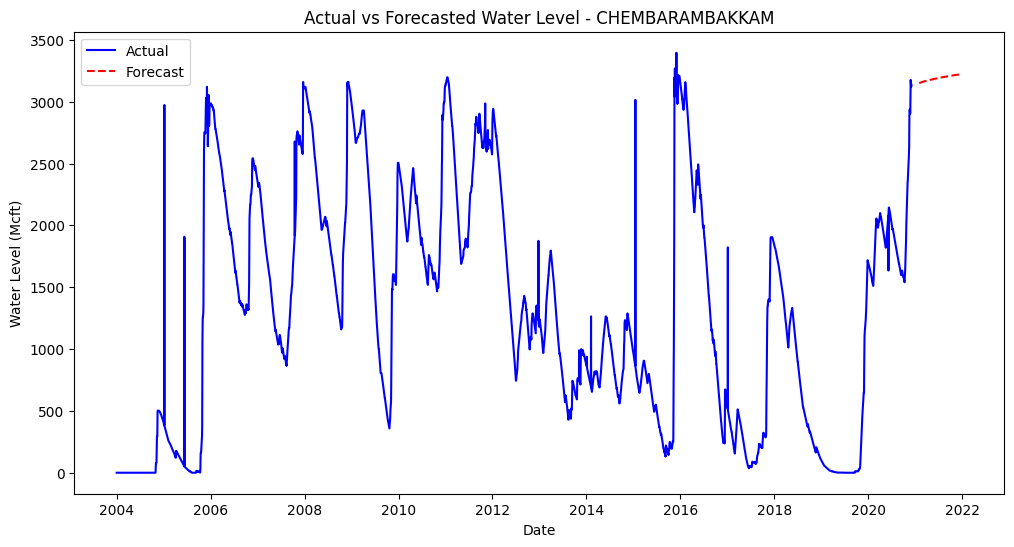

Model Performance for CHEMBARAMBAKKAM - MSE: 2500.37, RMSE: 50.00


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

for col in ['POONDI', 'CHOLAVARAM', 'REDHILLS', 'CHEMBARAMBAKKAM']:    
    forecast_steps = 12
    forecast = sarima_fit.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=df['Date'].iloc[-1], periods=forecast_steps + 1, freq='MS')[1:]
    forecast_values = forecast.predicted_mean

    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df[col], label="Actual", color="blue")
    plt.plot(forecast_index, forecast_values, label="Forecast", color="red", linestyle="dashed")
    plt.xlabel("Date")
    plt.ylabel("Water Level (Mcft)")
    plt.title(f"Actual vs Forecasted Water Level - {col}")
    plt.legend()
    plt.show()

    train_size = len(df) - forecast_steps
    train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]
    predictions = sarima_fit.get_prediction(start=test_data.index[0], end=test_data.index[-1]).predicted_mean

    mse = mean_squared_error(test_data[col], predictions)
    rmse = np.sqrt(mse)

    print(f"Model Performance for {col} - MSE: {mse:.2f}, RMSE: {rmse:.2f}")


## LSTM Section

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [25]:
df = pd.read_csv(r"C:\Users\Albin\Desktop\TIME_SERIES_ANALYSIS\Project\chennai_reservoir_levels.csv", parse_dates=["Date"], dayfirst=True)
df.set_index("Date", inplace=True)
df = df[["POONDI", "CHOLAVARAM", "REDHILLS", "CHEMBARAMBAKKAM"]].dropna()


In [26]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

In [27]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(df_scaled, seq_length)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    LSTM(50),
    Dense(X.shape[2])
])
model.compile(optimizer='adam', loss='mse')

In [29]:
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)


Epoch 1/20

309/309 [==============================] - 12s 17ms/step - loss: 0.0084
Epoch 2/20
309/309 [==============================] - 5s 15ms/step - loss: 0.0018
Epoch 3/20
309/309 [==============================] - 6s 19ms/step - loss: 0.0015
Epoch 4/20
309/309 [==============================] - 7s 23ms/step - loss: 0.0013
Epoch 5/20
309/309 [==============================] - 7s 22ms/step - loss: 0.0011
Epoch 6/20
309/309 [==============================] - 5s 15ms/step - loss: 0.0010
Epoch 7/20
309/309 [==============================] - 5s 15ms/step - loss: 9.3703e-04
Epoch 8/20
309/309 [==============================] - 5s 16ms/step - loss: 8.5505e-04
Epoch 9/20
309/309 [==============================] - 5s 16ms/step - loss: 7.7571e-04
Epoch 10/20
309/309 [==============================] - 4s 14ms/step - loss: 7.8501e-04
Epoch 11/20
309/309 [==============================] - 5s 15ms/step - loss: 7.5371e-04
Epoch 12/20
309/309 [==============================] - 6s 19ms/step - loss

In [30]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)


39/39 [==============================] - 3s 9ms/step


In [31]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = sqrt(mse)

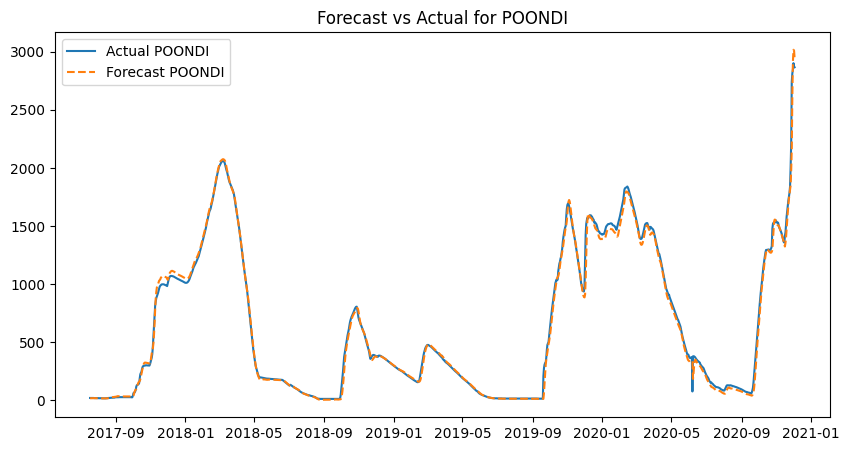

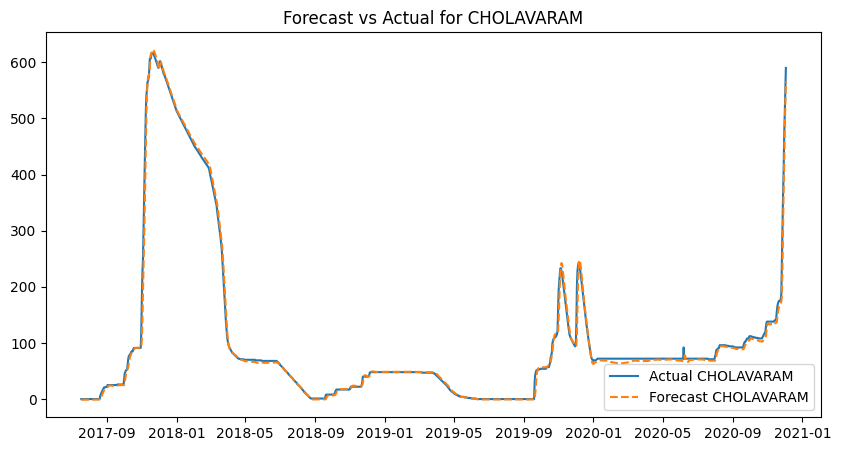

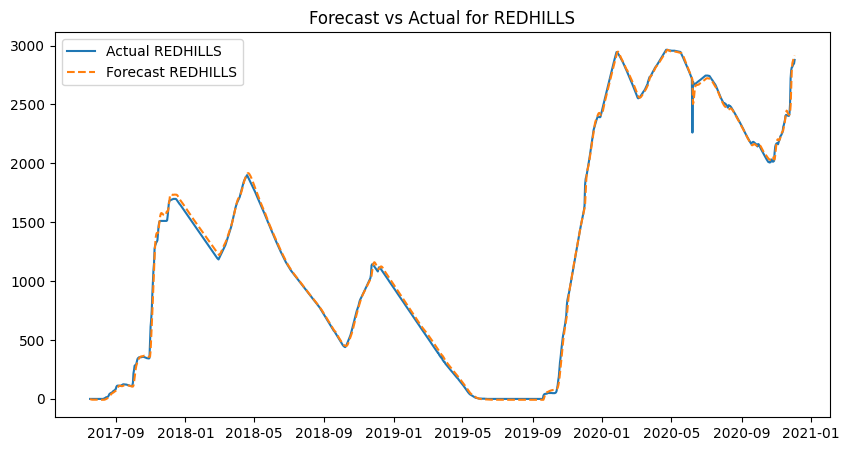

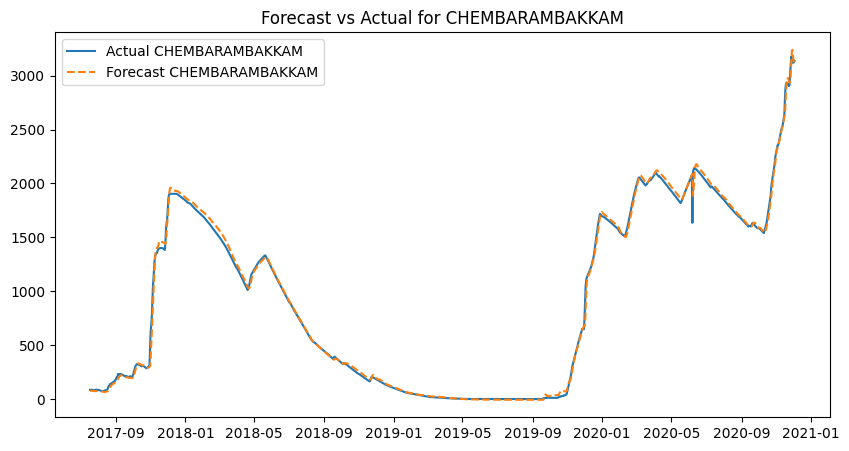

MSE: 1040.2627134438023
RMSE: 32.253103935029294


In [32]:
for i, col in enumerate(df.columns):
    plt.figure(figsize=(10,5))
    plt.plot(df.index[train_size+seq_length:], y_test_inv[:, i], label=f"Actual {col}")
    plt.plot(df.index[train_size+seq_length:], y_pred_inv[:, i], label=f"Forecast {col}", linestyle='dashed')
    plt.title(f"Forecast vs Actual for {col}")
    plt.legend()
    plt.show()

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

target_col = 'POONDI'

forecast_steps = 12

train = df.iloc[:-forecast_steps]
test = df.iloc[-forecast_steps:]

start_idx = len(train)
end_idx = len(train) + forecast_steps - 1

sarima_pred = sarima_fit.get_prediction(start=start_idx, end=end_idx).predicted_mean.values

lstm_pred_scaled = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()

# Actual values
actual = test[target_col].values
sarima_rmse = np.sqrt(mean_squared_error(actual, sarima_pred))
sarima_mse = mean_squared_error(actual, sarima_pred)

print(f"SARIMA - RMSE: {sarima_rmse:.2f}, MSE: {sarima_mse:.2f}")
print(f"LSTM   - RMSE: {rmse}, MSE: {mse}")


39/39 [==============================] - 0s 7ms/step
SARIMA - RMSE: 803.11, MSE: 644978.72
LSTM   - RMSE: 32.253103935029294, MSE: 1040.2627134438023
